# Project Time Series - Soft-DTW
## Roman Plaud Clémence Grislain

In this notebook we experiment time series classification and prediction using Soft-DTW introduced in the paper "Soft-DTW: a Differentiable Loss Function for Time-Series" by Marco Cuturi, Mathieu Blondel (2017) https://arxiv.org/abs/1703.01541

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/TIME SERIES/PROJECT/time_series_project"
path = "/content/drive/MyDrive/MVA/TIMES SERIES/time_series_project"

%cd $path

/content/drive/.shortcut-targets-by-id/10zxRnOT9t2K1Yd4TpOBJnFNdtVbE9NTI/time_series_project


In [3]:
!pip install numba tslearn fastdtw dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-linux_x86_64.whl size=534339 sha256=0425ca46dbc9396c19b4427a5899eed163ced951fb3ce60afad6bff00b036b22
  Stored in directory: /root/.cache/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5313 sha256=53c5202ff43ed0404caa726e9abbd87537fc9397a5988897b83d53f754585f7d
  Stored in directory: /root/.cache/pip/wheels/b4/fe/94/72ad3df3a67605236d3fac0891a64eef2eeedad1a1e0639076
Successfully built fastdtw dtw


In [4]:
# Come from GitHub source code attached with the paper
from numba_ops import *
from soft_dtw_cuda import SoftDTW

import numpy as np
import matplotlib.pyplot as plt
import os.path
from tqdm import tqdm, trange
from dtw import dtw
from fastdtw import fastdtw
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.neighbors import NearestNeighbors
import pickle as pkl
import time
from tqdm import trange
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from math import ceil

### Data

We download the datasets from UCR Time Series Archive (https://arxiv.org/abs/1810.07758)

The following cell is extracted from GitHub source code of SDTW (https://github.com/mblondel/soft-dtw)

In [5]:
data_dir = os.path.join(path, "sdtw_data")
ucr_dir = data_dir


def _parse_ucr(filename):
    y = []
    X = []
    for line in open(filename):
        line = line.strip()
        arr = line.split(",")
        label = int(arr[0])
        feat = list(map(float, arr[1:]))
        feat = np.array(feat).reshape(-1, 1)
        y.append(label)
        X.append(feat)
    return X, np.array(y)


def list_ucr():
    return sorted(os.listdir(ucr_dir))


def load_ucr(name):
    folder = os.path.join(ucr_dir, name)
    tr = os.path.join(folder, "%s_TRAIN" % name)
    te = os.path.join(folder, "%s_TEST" % name)

    try:
        X_tr, y_tr = _parse_ucr(tr)
        X_te, y_te = _parse_ucr(te)
    except IOError:
        raise IOError("Please copy UCR_TS_Archive_2015/ to $HOME/sdtw_data/. "
                      "Download from www.cs.ucr.edu/~eamonn/time_series_data.")

    y_tr = np.array(y_tr)
    y_te = np.array(y_te)
    X_tr = np.array(X_tr)
    X_te = np.array(X_te)

    return X_tr, y_tr, X_te, y_te

def normalize(X):
  # Normalize signals (zero mean, unit variance).
  X -= X.mean(axis=1).reshape(-1, 1, 1)
  X /= X.std(axis=1).reshape(-1, 1, 1)
  return X

## Classification

To perform time series classification, we implement:
*  K-NN classifier based on DTW metric (which will be our baseline)
*  Nearest centroids classifiers using
  * MSE
  * DTW
  * Soft DTW

We will compare these approaches in term of accuracy on '50words' dataset.

### Utils

In [6]:
# Define a decorator for timing function execution
def time_it(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time of {func.__name__}: {np.round(end - start, 4)} s")
        return result
    return wrapper

# Display the centroid for a given class (qualitative analysis)
def display_centroids(n_examples, label, barycenters, X_tr, y_tr, X_te, y_te, names=['euclidian', 'dtw', 'stdw']):

    colors = ['black', 'darkgreen', 'darkblue']
    colors_test_train = ['slategray', 'silver']

    for ii,bary in enumerate(barycenters):
      fig = plt.figure(figsize=(10,5))

      for idx, (X,y) in enumerate([(X_tr, y_tr), (X_te, y_te)]):
        if n_examples==None:
          X_ll = X[y==label]
        else:
          X_ll = X[y==label][:n_examples]
        color = np.random.rand(3)
        fig.add_subplot(1,2,idx+1)
        for x in X_ll:
          plt.plot(x, c=colors_test_train[idx])

        plt.plot(bary[label-1], color=colors[ii], linewidth=3)
        if idx == 0: plt.title("Train")
        else : plt.title("Test")

      fig.suptitle(f"Examples and centroid of class {label} computed using {names[ii]} metric")
      plt.show();

### Compute centroids

In [7]:
def euclidan_barycenter(X):
    return np.mean(X, axis=0)

# Compute barycenter on training set using a certain metric and evaluate on the test set
@time_it
def run_centroid_classification(X_tr, y_tr, X_te, y_te, metric, gamma=1.):

    # Compute the barycenters from the train set
    labels = np.unique(y_tr)
    barycenters = list()
    for label in labels:

        if metric=='sdtw':
            bary = barycenter(X_tr[y_tr==label], X_init='sdtw', 
                              value_and_grad=lambda x,y: sdtw_div_value_and_grad(x, y, gamma=gamma), 
                              max_iter=100)
        elif metric=='dtw':
            bary = dtw_barycenter_averaging(X_tr[y_tr==label], max_iter=100)
        elif metric=='euclidian':
            bary = euclidan_barycenter(X_tr[y_tr==label])
        else:
            print("Error distance not known")
        barycenters.append(bary)

    # Predict on the test set
    N, M = len(labels), len(y_te)
    K_test = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            if metric=='sdtw':
                dist = sdtw(barycenters[i], X_te[j], gamma=gamma)
            elif metric=='dtw':
                dist = fastdtw(barycenters[i], X_te[j])[0]
            elif metric=='euclidian':
                dist = np.linalg.norm(barycenters[i] -  X_te[j])
            else: 
                raise Exception("Unknown metric")
            K_test[i,j] = dist
    
    pred = labels[K_test.argmin(axis=0)]
    acc = (pred==y_te).mean()

    return acc, barycenters, pred

### Experiments

#### On the dataset *50words*

'50words' is a dataset of word outlines, more speciafically height profiles of words, taken from the George Washington library documented by T. Rath. This dataset was extracted from UCR Archive https://timeseriesclassification.com/dataset.php.

As there are no recurrent phenomena that could lead to noise, the only useful preprocessing step is to apply normalization (with a zero mean and variance of 1) on the data. This preprocessing step has already been applied in the downloaded dataset.

In [13]:
dataset = '50words'

# Load dataset
X_tr, y_tr, X_te, y_te = load_ucr(dataset)

print("Number of classes:", len(np.unique(y_tr)))
print("Number of training data:", X_tr.shape[0])
print("Number of testing data:", X_te.shape[0])


Number of classes: 50
Number of training data: 450
Number of testing data: 455


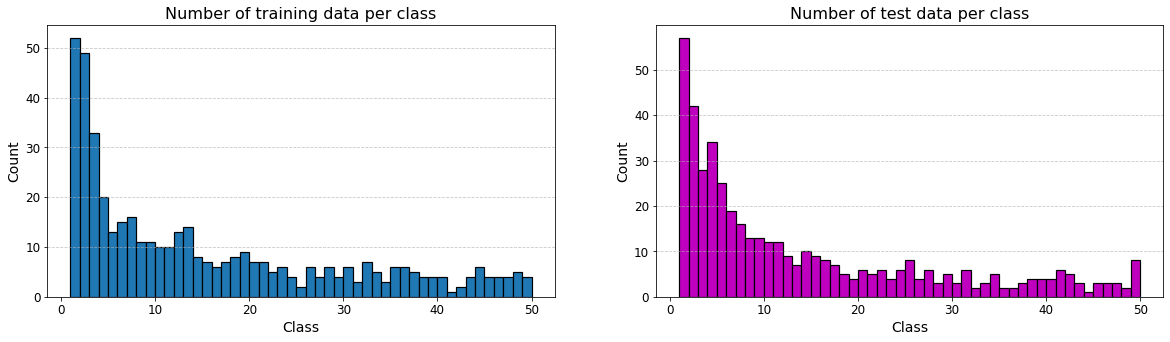

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))

hist = ax[0].hist(y_tr, bins=np.arange(1, 51), edgecolor='black', linewidth=1.2)

# set the title and axis labels
ax[0].set_title('Number of training data per class', fontsize=16)
ax[0].set_xlabel('Class', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)

# customize the tick labels
ax[0].tick_params(axis='both', which='major', labelsize=12)

# add a grid to the plot
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

hist = ax[1].hist(y_te, bins=np.arange(1, 51), edgecolor='black', linewidth=1.2, color='m')

# set the title and axis labels
ax[1].set_title('Number of test data per class', fontsize=16)
ax[1].set_xlabel('Class', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)

# customize the tick labels
ax[1].tick_params(axis='both', which='major', labelsize=12)

# add a grid to the plot
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# show the plot
plt.show()

Data are centered and normalized

In [ ]:
print(f"Mean: {X_tr.mean(axis=1).mean():.2f} +/- {1.96 * np.sqrt(X_tr.mean(axis=1).std())/len(X_tr):.4e}")
print(f"Standard deviation: {X_tr.std(axis=1).mean():.2f} +/- {1.96 * np.sqrt(X_tr.std(axis=1).std())/len(X_tr):.4e}")

Mean: -0.00 +/- 3.9958e-06
Standard deviation: 1.00 +/- 5.6789e-06


In [ ]:
# Split the train set into Train/Val for cross validation
ratio = 0.8

# Pick 80% of each class for the train and 20% for the validation
# (at least 1 data per class in the validation set)

labels = np.unique(y_tr)
train_index = []
val_index = []

for label in labels:
  label_idx = set(np.where(y_tr==label)[0])
  
  # Create validation set 
  n_val = ceil((1. - ratio) * len(label_idx))
  for _ in range(n_val):
    idx = np.random.choice(list(label_idx))
    val_index.append(idx)
    label_idx.remove(idx)
  
  # Add the rest to train set
  for idx in label_idx:
    train_index.append(idx)

In [ ]:
print(f"Reduced training set {len(train_index)} data")
print(f"Validation set {len(val_index)} data")

Reduced training set 339 data
Validation set 111 data


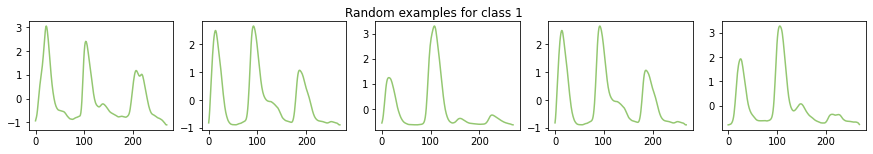

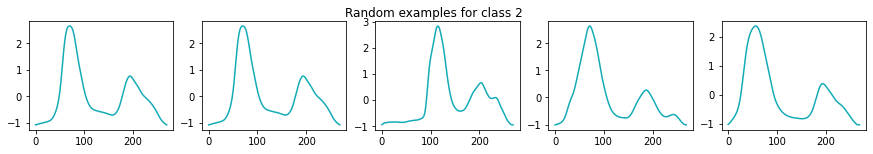

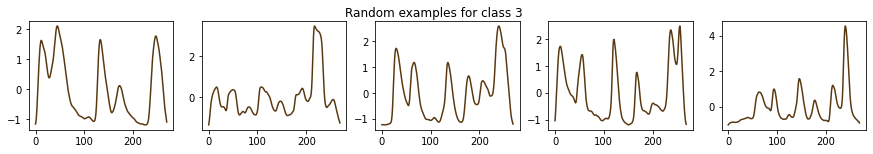

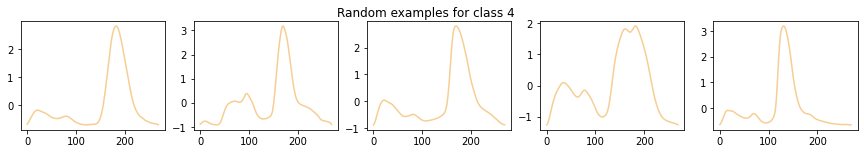

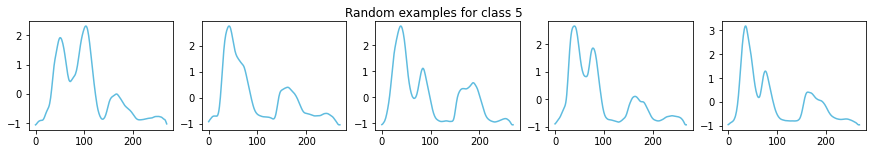

In [ ]:
n_labels = 5
n_examples = 5

for ll in np.unique(y_tr)[:n_labels]:
    X_ll = X_tr[y_tr==ll]
    color = np.random.rand(3)
    fig = plt.figure(figsize=(15,2))
    for i in range(n_examples):
        fig.add_subplot(1,n_examples,i+1)
        plt.plot(X_ll[np.random.randint(0,len(X_ll))], c=color)
    fig.suptitle(f'Random examples for class {ll}')
plt.show();

#### Clustering with K-NN using DTW

In [ ]:
# Distance map train on train (DTW distance matrix)
n_train = len(X_tr)
distance_matrix = np.zeros((n_train, n_train))

for i in range(n_train):
  for j in range(i+1, n_train):
    distance_matrix[i,j] = fastdtw(X_tr[i], X_tr[j])[0]
    distance_matrix[j,i] = distance_matrix[i,j]

In [ ]:
# Test on train (DTW distance matrix)
n_test = len(X_te)
distance_matrix_test = np.zeros((n_test,n_train))

for i in range(n_test):
  for j in range(n_train):
    distance_matrix_test[i,j] = fastdtw(X_te[i], X_tr[j])[0]

In [ ]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

##### Cross validation of the number of neighbord (K)

In [ ]:
# Train on the reduced training set
# Evaluate on the validation set

means_acc = []
for number_neighbors in trange(1,20):

  # Get the training and validation distance matrices 
  dist_mat_train = distance_matrix[np.ix_(train_index, train_index)]
  dist_mat_val = distance_matrix[np.ix_(val_index, train_index)]

  y_train, y_val = y_tr[train_index], y_tr[val_index]

  # Training
  knn = KNeighborsClassifier(n_neighbors=number_neighbors, metric="precomputed")
  knn.fit(dist_mat_train, y_train)

  # Evaluation on the validation set
  y_pred = knn.predict(dist_mat_val) 
  mean_acc = (y_pred==y_val).mean()
  
  means_acc.append(mean_acc)

100%|██████████| 19/19 [00:00<00:00, 110.86it/s]


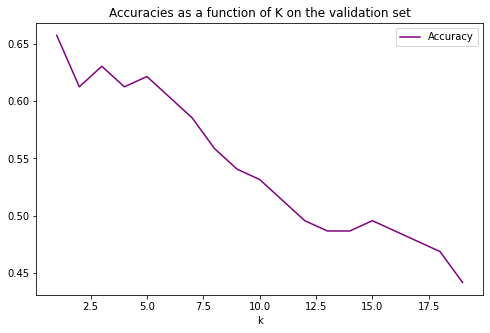

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,20), means_acc, label='Accuracy', c='purple')
plt.xlabel("k")
plt.legend()
plt.title("Accuracies as a function of K on the validation set");

In [ ]:
print(f"Best K k={np.argmax(means_acc)+1}: accuracy {np.max(means_acc):.4f}")

Best K k=1: accuracy 0.6577


##### Evaluation on the test set

In [ ]:
k = 1
knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
knn.fit(distance_matrix, y_tr)

# Evaluation on test set
y_pred_test = knn.predict(distance_matrix_test)
acc_test = (y_pred_test==y_te).mean()

print(f"KNN classification with k={k} on the test set achives: accuracy {acc_test:.4f}")

KNN classification with k=1 on the test set achives: accuracy 0.7209


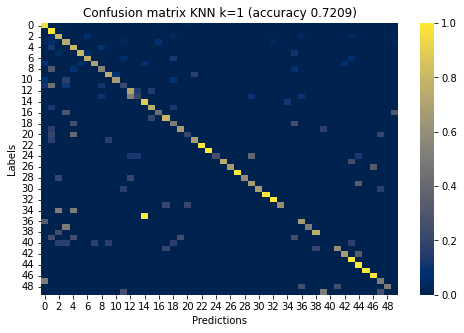

In [ ]:
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_te, y_pred_test, normalize='true')
sns.heatmap(cm, cmap='cividis', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title(f'Confusion matrix KNN k={k} (accuracy {acc_test:.4f})');

#### Compute centroids

##### Cross validation on $\gamma$ parameter of the SDTW

In [ ]:
gammas = np.linspace(0.001, 1, 20)
accuracies = []

# Compute the centroid on the reduced training set
# Evaluate on the validation set

X_train, X_val = X_tr[train_index], X_tr[val_index]
y_train, y_val = y_tr[train_index], y_tr[val_index]

for gamma in tqdm(gammas):
  acc_sdtw, _, _ = run_centroid_classification(X_train, y_train, X_val, y_val, 'sdtw', gamma=gamma)
  accuracies.append(acc_sdtw)

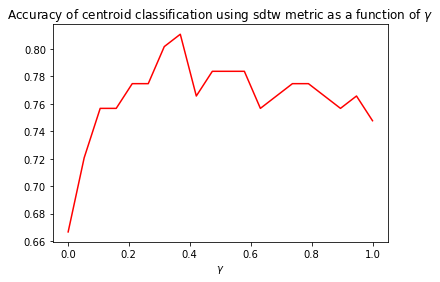

In [ ]:
plt.plot(gammas, accuracies, label='Accuracy', c='r')
plt.xlabel('$\gamma$')
plt.title("Accuracy of centroid classification using sdtw metric as a function of $\gamma$ (on validation set)");

In [ ]:
best_gamma = gammas[np.argmax(accuracies)]
print(f"Best gamma {best_gamma:.4f} accuracy {np.max(accuracies):.4f}")

Best gamma 0.3691 accuracy 0.8108


##### Centroids visualization and evaluation

In [ ]:
gamma = best_gamma

acc_eucl, barycenters_euclidian, pred_eucl = run_centroid_classification(X_tr, y_tr, X_te, y_te, 'euclidian')
acc_dtw, barycenters_dtw, pred_dtw = run_centroid_classification(X_tr, y_tr, X_te, y_te, 'dtw')
acc_sdtw, barycenters_sdtw, pred_sdtw = run_centroid_classification(X_tr, y_tr, X_te, y_te, 'sdtw', gamma=gamma)

print(f"Euclidian centroids accuracy:  {acc_eucl:.4f}")
print(f"DTW centroids       accuracy:  {acc_dtw:.4f}")
print(f"SDTW centroids      accuracy:  {acc_sdtw:.4f}")

Execution time of run_centroid_classification: 0.224 s
Execution time of run_centroid_classification: 53.3373 s
Execution time of run_centroid_classification: 481.4369 s
Euclidian centroids accuracy:  0.5165
DTW centroids       accuracy:  0.6264
SDTW centroids      accuracy:  0.7275


In [17]:
label = 6
bary_mse = euclidan_barycenter(X_tr[y_tr==label])
bary_dtw = dtw_barycenter_averaging(X_tr[y_tr==label], max_iter=100)
bary_sdtw = barycenter(X_tr[y_tr==label], X_init='sdtw', 
                              value_and_grad=lambda x,y: sdtw_div_value_and_grad(x, y, gamma=1), 
                              max_iter=100)
barys = [bary_mse, bary_dtw, bary_sdtw]

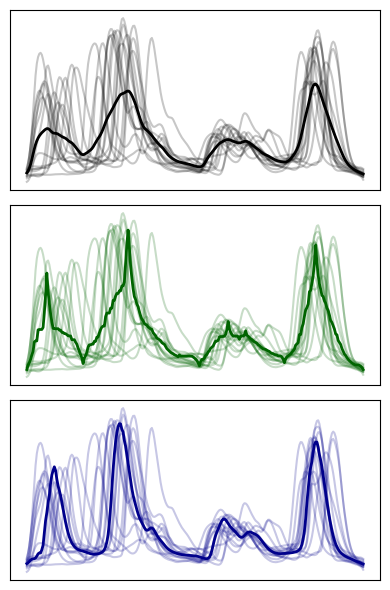

In [25]:
colors = ['black', 'darkgreen', 'darkblue']
fig, ax = plt.subplots(3, 1, figsize=(4,6))
for i, (bary, color) in enumerate(zip(barys, colors)):
  for x in X_tr[y_tr==label]: 
    ax[i].plot(x, color, alpha=.22)
  ax[i].plot(bary, color, linewidth=2)
  ax[i].tick_params(axis='both', which='both', length=0, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.tight_layout()

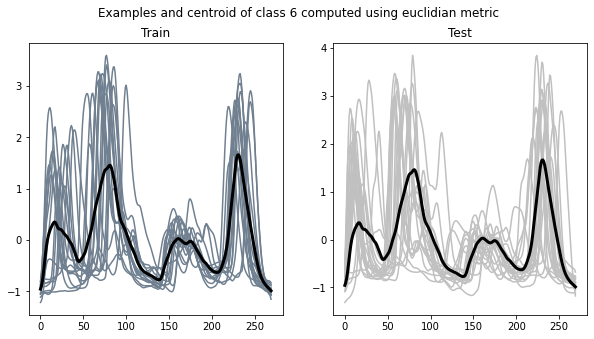

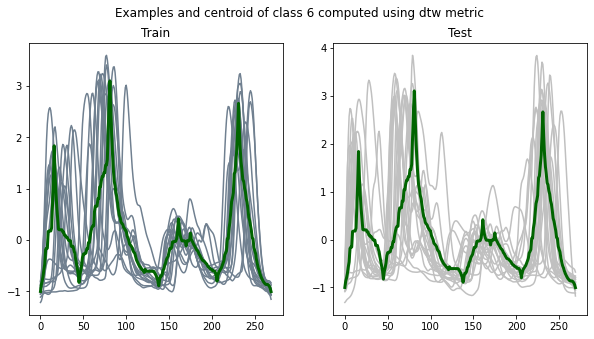

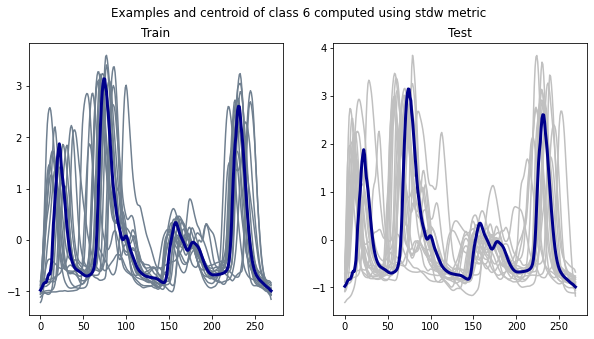

In [ ]:
label = 6
n_examples = None

display_centroids(n_examples, label, [barycenters_euclidian, barycenters_dtw, barycenters_sdtw], X_tr, y_tr, X_te, y_te)

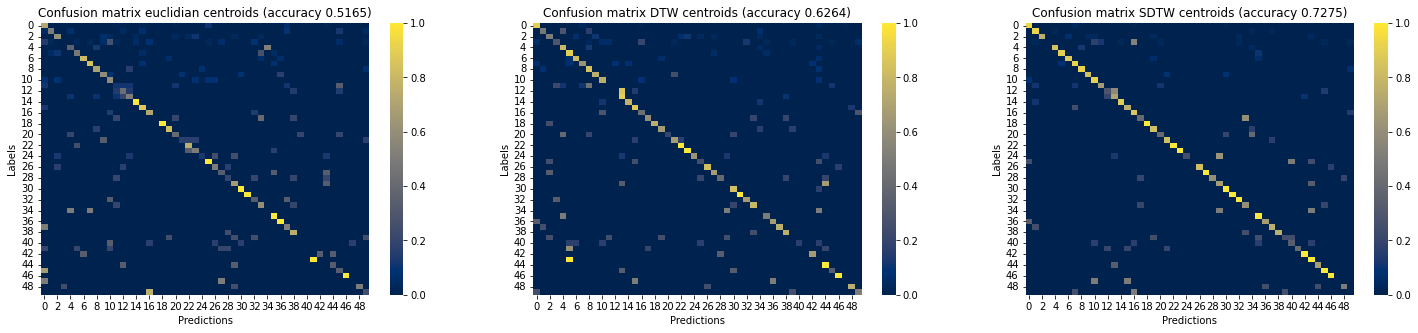

In [ ]:
# Confusion matrices

fig = plt.figure(figsize=(25,5))

fig.add_subplot(1,3,1)
cm = confusion_matrix(y_te, pred_eucl, normalize='true')
sns.heatmap(cm, cmap='cividis', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title(f'Confusion matrix euclidian centroids (accuracy {acc_eucl:.4f})')

fig.add_subplot(1,3,2)
cm = confusion_matrix(y_te, pred_dtw, normalize='true')
sns.heatmap(cm, cmap='cividis', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title(f'Confusion matrix DTW centroids (accuracy {acc_dtw:.4f})')

fig.add_subplot(1,3,3)
cm = confusion_matrix(y_te, pred_sdtw, normalize='true')
sns.heatmap(cm, cmap='cividis', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.title(f'Confusion matrix SDTW centroids (accuracy {acc_sdtw:.4f})')
plt.show()

## Multi step ahead prediction

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import trange

In [7]:
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

print(f"Working on {device}")

Working on cpu


### Utils

In [8]:
def euclidian_metric(x,y):
  return np.linalg.norm(x-y)

def dtw_metric(x,y):
  return fastdtw(x,y)[0]

def display_training_curves(train_losses, val_losses, 
                            train_metric_eucl, val_metric_eucl,
                            train_metric_dtw, val_metric_dtw):
  fig = plt.figure(figsize=(25,5))

  fig.add_subplot(1,3,1)
  plt.plot(val_losses, label="val", c='b')
  plt.plot(train_losses, label="train", c='m')
  plt.xlabel('epochs')
  plt.ylabel('SDTW loss')
  plt.title("Evolution of the training SDTW loss")
  plt.legend();

  fig.add_subplot(1,3,2)
  plt.plot(val_metric_dtw, label="val", c='b')
  plt.plot(train_metric_dtw, label="train", c='m')
  plt.xlabel('epochs')
  plt.ylabel('DTW metric')
  plt.title("Evolution of the training and validation DTW metric")

  plt.legend();

  fig.add_subplot(1,3,3)
  plt.plot(val_metric_eucl, label="val", c='b')
  plt.plot(train_metric_eucl, label="train", c='m')
  plt.xlabel('epochs')
  plt.ylabel('euclidian metric')
  plt.title("Evolution of the training and validation euclidian metric")
  plt.legend();

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      x = self.layer1(x)
      x = self.sigmoid(x)
      x = self.layer2(x)
      return x

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataset, percentage=0.6):
        self.data = dataset
        self.input_size = int(len(dataset[0]) * percentage)
        self.output_size = len(dataset[0]) - self.input_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        time_series = self.data[idx]
        x = torch.tensor(time_series[:self.input_size,0], dtype=torch.float32)
        y = torch.tensor(time_series[self.input_size:], dtype=torch.float32)
        return x, y

In [11]:
# Training step
def train(loader, model, loss_fn, optimizer, device=device):
    # Training mode
    model.train()

    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
      # Put data on device
      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)[:,:,None]

      # Backpropagation
      loss = loss_fn(outputs, targets)
      loss = loss.mean()
      loss.backward()
      
      optimizer.step()
      total_loss += loss.item()
    
    return total_loss / len(loader)

In [12]:
# Function that computes evaluation metrics
def test(loader, model, loss_fn=dtw_metric, device=device, dtw=True, return_list=False):
    # Evaluation mode
    model.eval()

    loss = 0.0

    if return_list: 
      list_loss = list()

    for batch_idx, (inputs, targets) in enumerate(loader):
      # Put data on device
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)[:,:,None]

      if not dtw:
          l = loss_fn(outputs, targets)
          l = l.sum()
          loss += l.item()

          if return_list : 
            list_loss.append(l.detach().cpu().numpy())
      else : 

        for output, target in zip(targets, outputs):
          l = loss_fn(output.detach().cpu().numpy(), target.detach().cpu().numpy())
          loss += l
        if return_list : 
          list_loss.append(l)
    if return_list: 
      return list_loss
    else :
      return loss / len(loader)

In [13]:
def train_mlp(ds_train,
              ds_val,
              batch_size=128, 
              epochs=100, 
              lr=0.01, 
              loss_fn=SoftDTW(use_cuda=(device=='cuda'), gamma=0.01),
              path_model = "model", 
              device=device,
              save=False, 
              metrics_computation=True
              ):

  # Create dataloaders
  loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
  loader_val = DataLoader(ds_val, batch_size=batch_size)

  # Parametrize MLP model
  input_size = ds_train.input_size 
  output_size = ds_train.output_size
  hidden_size = 256

  # Init model
  model = MLP(input_size, hidden_size, output_size)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.to(device)

  best_model = model
  best_val_loss = float("inf")

  # For display
  train_losses = []
  val_losses = []

  val_metric_eucl = []
  train_metric_eucl = []

  val_metric_dtw = []
  train_metric_dtw = []

  # Training loop
  for e in trange(epochs):
      train_loss = train(loader_train, model, loss_fn, optimizer)
      train_losses.append(train_loss)

      if metrics_computation : 

        # Metrics
        train_euclidian = test(loader_train, model, loss_fn=torch.nn.MSELoss(), device=device, dtw=False) / batch_size
        val_euclidian = test(loader_val, model, loss_fn=torch.nn.MSELoss(), device=device, dtw=False) / batch_size
        train_metric_eucl.append(train_euclidian)
        val_metric_eucl.append(val_euclidian)

        train_dtw = test(loader_train, model, device=device) / batch_size
        val_dtw = test(loader_val, model, device=device) / batch_size
        train_metric_dtw.append(train_dtw)
        val_metric_dtw.append(val_dtw)

      val_loss = test(loader_val, model, loss_fn=loss_fn, device=device, dtw=False) / batch_size
      val_losses.append(val_loss)


      # Evaluate the model on validation set
      if best_val_loss > val_loss:
          best_val_loss = val_loss
          best_model = model

          # Save best model
  if save:
        torch.save(best_model.state_dict(), path_model)

  return (best_val_loss, best_model, 
          train_losses, val_losses, 
          train_metric_eucl, val_metric_eucl,
          train_metric_dtw, val_metric_dtw)


### Experiments

#### On the dataset 'ECG5000'

The 'ECG5000' dataset contains information about a person's heartbeats, thus one dimensional time series. The data are taken from a 20-hour long electrocardiogram (ECG) called the BIDMC Congestive Heart Failure Database (chfdb) in which researchers randomly selected 5,000 heartbeats -4500 for test set and 500 for training set. 

The data was pre-processed in two steps: 
* extract each heartbeat
* make each heartbeat equal length using interpolation. 

**Remark:** Even though this is not the focus of the study, the training dataset is labeled with 5 classes.

In [14]:
dataset = 'ECG5000'
train_size=0.9

# Load dataset
X_tr, y_tr, X_te, y_te = load_ucr(dataset)
X_train, X_val = train_test_split(X_tr, train_size=train_size, random_state=42)

# Extract masked training/validation/test data
ds_train = TimeSeriesDataset(X_train)
ds_val = TimeSeriesDataset(X_val)
ds_test = TimeSeriesDataset(X_te)

print(f"Reduced training set: {len(ds_train)} data")
print(f"Validation set: {len(ds_val)} data")
print(f"Test set: {len(ds_test)} data")

Reduced training set: 450 data
Validation set: 50 data
Test set: 4500 data


In [15]:
x, y = ds_train[0]

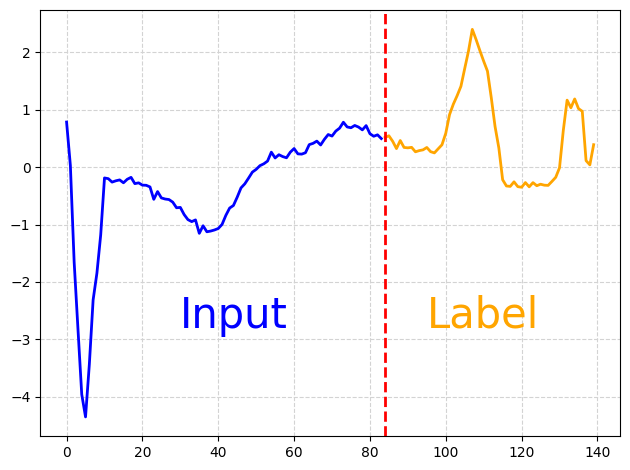

In [33]:
plt.plot(range(len(x)), x, color='blue', linewidth=2)
plt.plot(range(len(x), len(x) + len(y)), y, color='orange', linewidth=2)

# Add the vertical line
plt.axvline(x=len(x), color='red', linestyle='--', linewidth=2)

plt.grid(color='lightgray', linestyle='--')

# # Add labels to the plot
plt.text(30, -2.8, 'Input', fontsize=30, color='blue')
plt.text(95, -2.8, 'Label', fontsize=30, color='orange')
plt.tight_layout()

plt.savefig('example_prediction.png')

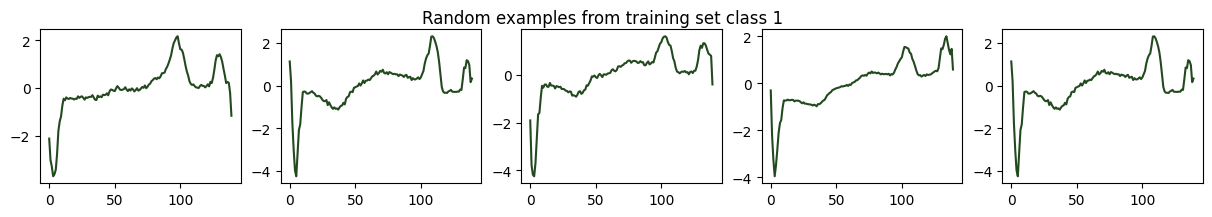

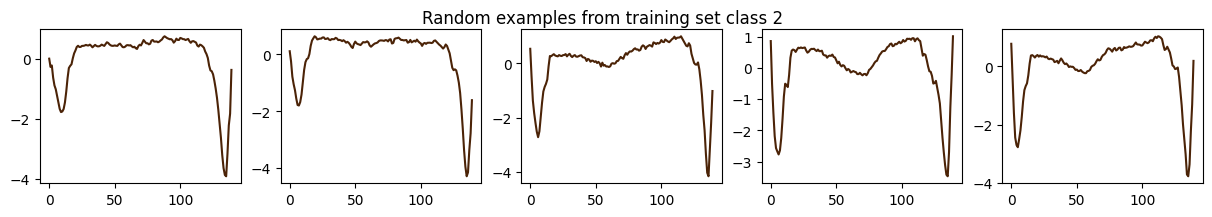

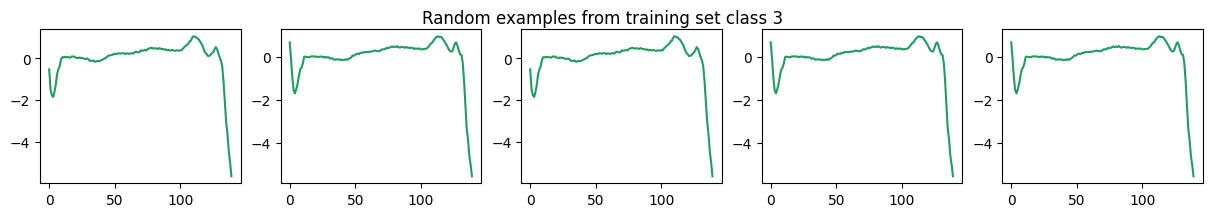

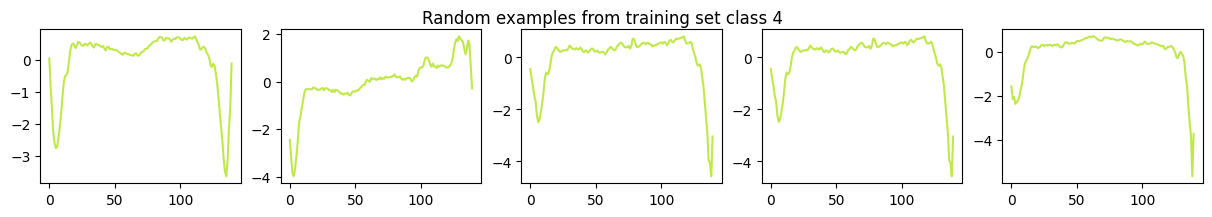

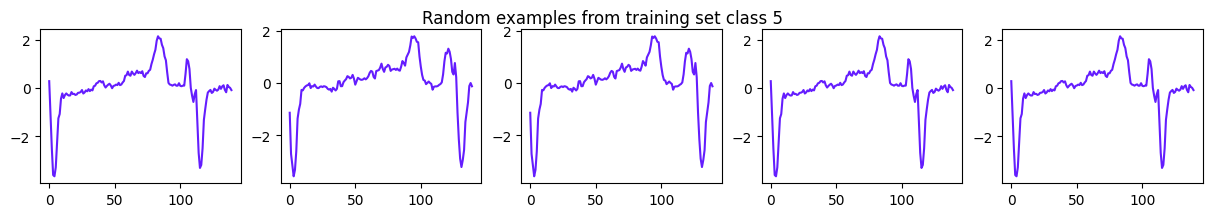

In [35]:
# Display the different time series profiles
labels = np.unique(y_tr)

for ll in labels:
  fig = plt.figure(figsize=(15,2))
  color = np.random.rand(3)
  for i in range(5):
    fig.add_subplot(1,5,i+1)
    X_ll = X_tr[np.where(y_tr==ll)[0]]
    plt.plot(X_ll[np.random.randint(0,len(X_ll))], c=color)
  fig.suptitle(f"Random examples from training set class {ll}");

#### Training using sdtw loss with $\gamma=0.01$

In [17]:
# Hyperparameters
epochs = 100
batch_size = 3
lr = 0.001
gamma = 0.05

# Create dataloaders
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size)
loader_test = DataLoader(ds_test, batch_size=1)

# Sdtw loss
loss_fn = SoftDTW(use_cuda=True, gamma=gamma)
#loss_fn = torch.nn.MSELoss()


# Training
best_val_loss, best_model, train_losses, val_losses, train_metric_eucl, val_metric_eucl, train_metric_dtw, val_metric_dtw = train_mlp(ds_train, 
                                                                                                                            ds_val, 
                                                                                                                            epochs=epochs, 
                                                                                                                            loss_fn=loss_fn,
                                                                                                                            batch_size=batch_size,
                                                                                                                            lr=lr,
                                                                                                                            path_model='models/model_ECG5000_gamma0_05', 
                                                                                                                            metrics_computation=True)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


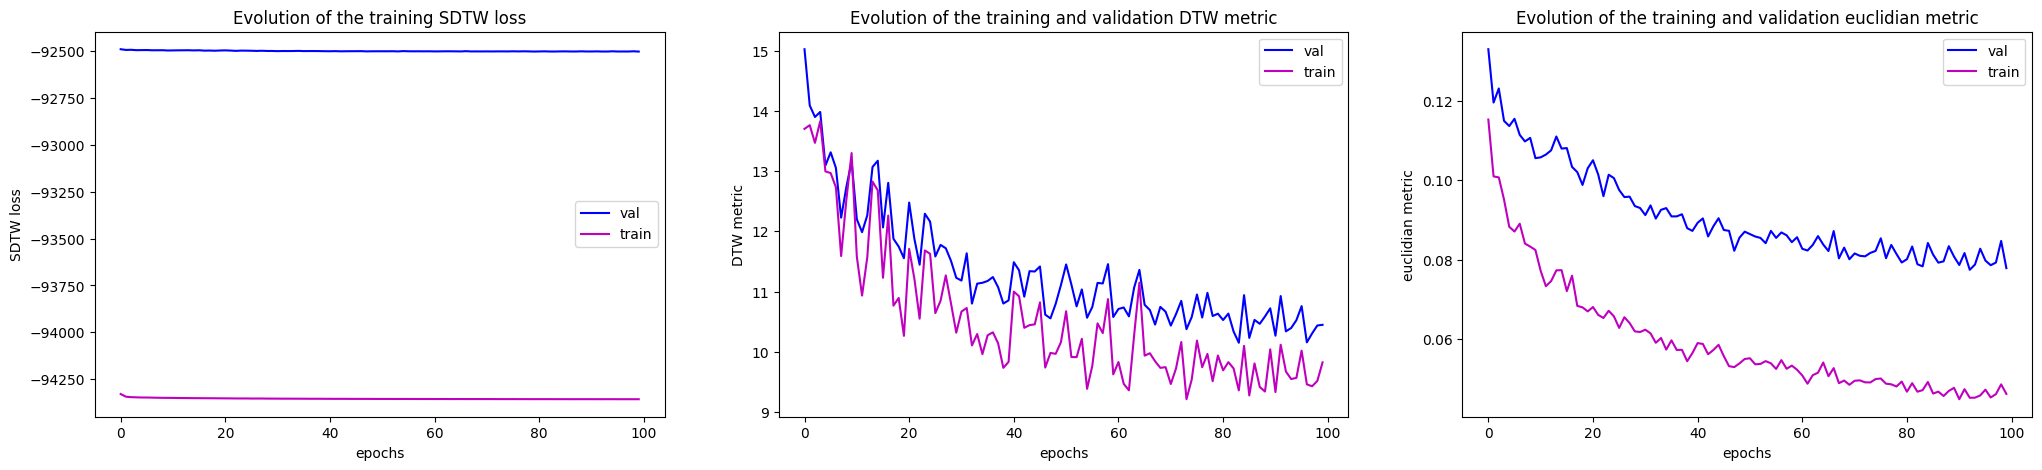

In [38]:
display_training_curves(train_losses, val_losses,
                        train_metric_eucl, val_metric_eucl,
                        train_metric_dtw, val_metric_dtw)

In [ ]:
# Evaluation

# DTW metric
DTW_test =  test(loader_test, best_model, device='cuda')
# Euclidian
Euclidian_test =  test(loader_test, best_model, loss_fn=torch.nn.MSELoss(), device='cuda', dtw=False)

print(f"Metric on test set: \033[1m(DTW, Euclidian)=({DTW_test:.4f}, {Euclidian_test:.4f})\033[0m")

Metric on test set: (DTW, Euclidian)=(7.9353, 0.3480)


#### Browsing gamma dimension


##### Training with $SDTW^\gamma$

In [ ]:
# Hyperparameters
batch_size = 3
lr = 0.001
epochs = 100
dataset = 'ECG5000'

means = list()
stds = list()
X_tr, _, X_te, _ = load_ucr(dataset)
ds_test = TimeSeriesDataset(X_te)
loader_test = DataLoader(ds_test, batch_size=1)

# Browsing gamma dimensions
for gamma in tqdm(np.linspace(0.001, 1, 100)):

  loss_fn = SoftDTW(use_cuda=True, gamma=gamma)
  for i in range(5):
    x_tr, x_val = train_test_split(X_tr, train_size=train_size, random_state=i)

    # Extract masked training/validation/test data
    ds_train = TimeSeriesDataset(x_tr)
    ds_val = TimeSeriesDataset(x_val)

    # Create dataloaders
    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=batch_size)

    _, model, _, _, _, _, _, _ = train_mlp(ds_train,                                                                            
                                          ds_val, 
                                          epochs=epochs, 
                                          loss_fn=loss_fn,
                                          batch_size=batch_size,
                                          lr=lr,
                                          metrics_computation=False)
        
    list_loss_dtw =  test(loader_test, model, device='cuda', return_list=True)
    list_loss_eucl =  test(loader_test, model, loss_fn =torch.nn.MSELoss(), device='cuda', dtw=False, return_list=True)
    means.append((np.mean(list_loss_dtw), np.mean(list_loss_eucl)))
    stds.append((np.std(list_loss_dtw), np.std(list_loss_eucl)))

  pkl.dump([means, stds], open('results/results_SDTW.pkl', 'wb'))


##### Training with MSE

In [ ]:
# Hyperparameters
batch_size = 3
lr = 0.001
epochs = 100
dataset = 'ECG5000'

means = list()
stds = list()
X_tr, _, X_te, _ = load_ucr(dataset)
ds_test = TimeSeriesDataset(X_te)
loader_test = DataLoader(ds_test, batch_size=1)


loss_fn = torch.nn.MSELoss()
for i in range(5):
  x_tr, x_val = train_test_split(X_tr, train_size=train_size, random_state=i)

  # Extract masked training/validation/test data
  ds_train = TimeSeriesDataset(x_tr)
  ds_val = TimeSeriesDataset(x_val)

  # Create dataloaders
  loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
  loader_val = DataLoader(ds_val, batch_size=batch_size)

  _, model, _, _, _, _, _, _ = train_mlp(ds_train,                                                                            
                                        ds_val, 
                                        epochs=epochs, 
                                        loss_fn=loss_fn,
                                        batch_size=batch_size,
                                        lr=lr,
                                        metrics_computation=False)
      
  list_loss_dtw =  test(loader_test, model, device='cuda', return_list=True)
  list_loss_eucl =  test(loader_test, model, loss_fn = torch.nn.MSELoss(), device='cuda', dtw=False, return_list=True)
  means.append((np.mean(list_loss_dtw), np.mean(list_loss_eucl)))
  stds.append((np.std(list_loss_dtw), np.std(list_loss_eucl)))

pkl.dump([means, stds], open('results/results_MSE.pkl', 'wb'))

##### Load and display cross validation results

In [ ]:
means1, stds1 = pkl.load(open('results/results_SDTW.pkl', 'rb'))
means, stds = pkl.load(open('results/results_MSE.pkl', 'rb'))

In [ ]:
means_dtw_all = np.array([dtw for dtw, _ in means1])
means_eucl_all = np.array([eucl for _, eucl in means1])

stds_dtw = np.array([dtw for dtw, _ in stds1])
stds_eucl = np.array([eucl for _, eucl in stds1])

means_MSE_dtw = np.array([dtw for dtw, _ in means])
means_MSE_mse = np.array([mse for _, mse in means])

means_dtw_all = means_dtw_all.reshape(16,10)
means_eucl_all = means_eucl_all.reshape(16,10)

In [ ]:
means_dtw = means_dtw_all.mean(axis=1)
stds_dtw = means_dtw_all.std(axis=1)

means_eucl = means_eucl_all.mean(axis=1)
stds_eucl = means_eucl_all.std(axis=1)

mean_mse_dtw = means_MSE_dtw.mean()
std_mse_dtw = means_MSE_dtw.std()

mean_mse_mse = means_MSE_mse.mean()
std_mse_mse = means_MSE_mse.std()

In [ ]:
mean_mse_dtw = np.repeat(mean_mse_dtw, 16)
std_mse_dtw = np.repeat(std_mse_dtw, 16)

mean_mse_mse = np.repeat(mean_mse_mse, 16)
std_mse_mse = np.repeat(std_mse_mse, 16)

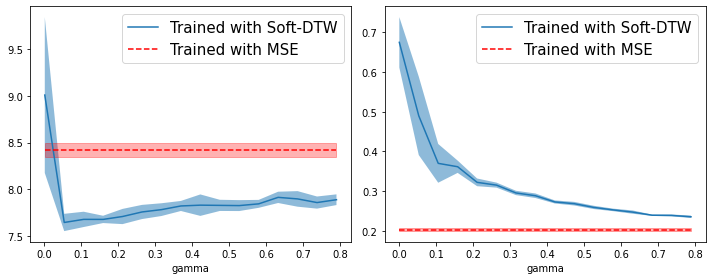

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
gammas = np.linspace(0.001, 1, 20)[:16]
N = 10
ax[0].plot(gammas, means_dtw, label='Trained with Soft-DTW')
ax[0].fill_between(gammas, means_dtw - (1.96/np.sqrt(N))*stds_dtw, means_dtw + (1.96/np.sqrt(N))*stds_dtw, alpha=0.5)
ax[0].plot(gammas, mean_mse_dtw, '--', c='red', label='Trained with MSE')
ax[0].fill_between(gammas, mean_mse_dtw - (1.96/np.sqrt(N))*std_mse_dtw, mean_mse_dtw + (1.96/np.sqrt(N))*std_mse_dtw, alpha=0.3, color='red')
ax[0].set(xlabel='gamma') #title='DTW loss on test set'

ax[0].legend(fontsize=15)

ax[1].plot(gammas, means_eucl, label='Trained with Soft-DTW')
ax[1].fill_between(gammas, means_eucl - (1.96/np.sqrt(N))*stds_eucl, means_eucl + (1.96/np.sqrt(N))*stds_eucl, alpha=0.5)
ax[1].plot(gammas, mean_mse_mse, '--', c='red', label='Trained with MSE')
ax[1].fill_between(gammas, mean_mse_mse - (1.96/np.sqrt(N))*std_mse_mse, mean_mse_mse + (1.96/np.sqrt(N))*std_mse_mse, alpha=0.3, color='red')
ax[1].set( xlabel='gamma')  #title='MSE loss on test set'
ax[1].legend(fontsize=15)
plt.tight_layout()


In [ ]:
fig.savefig('figures/evaluation.png')

#### Display models' outputs

In [18]:
loader_train = DataLoader(ds_train, batch_size=1, shuffle=False)
l = []
for x, y in (loader_test):
  input_cuda = x.to('cuda')
  pred = (best_model(input_cuda)[0][:, None].detach().cpu())
  loss_dtw = fastdtw(y[0], pred)[0]
  loss_eucl = euclidian_metric(y[0],pred)
  target = y[0,:,0]
  x = x[0]
  pred = pred[:,0]
  l.append([x, target, pred, loss_dtw, loss_eucl])

##### Example MSE model's output

DTW metric: 9.5353
Euclidian metric: 4.6467


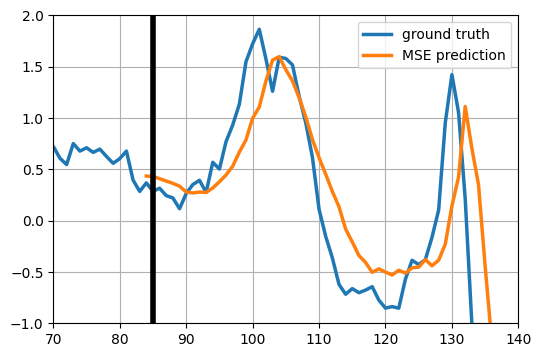

In [19]:
idx = 6

x, target, pred, loss_dtw, loss_eucl = l[idx]

print(f'DTW metric: {dtw_metric(target, pred):.4f}')
print(f'Euclidian metric: {euclidian_metric(target, pred):.4f}')

index_1 = range(len(x))
index_2 = range(len(x), len(x)+len(target))

plt.figure(figsize=(6,4))
plt.plot(np.concatenate([index_1, index_2]), np.concatenate([x, target]), label='ground truth', linewidth=2.5)
plt.plot(index_2, pred, label='MSE prediction', linewidth=2.5)
plt.axvline(x=len(x)+1, c='k', linewidth=4)
plt.xlim((70, 140))
plt.ylim((-1, 2))
plt.grid()
plt.legend(loc='upper right')
plt.savefig('MSE.png')

##### Example SDTW$^\gamma$ model's output ($\gamma$=0.001)

DTW metric: 3.3009
Euclidian metric: 1.1339


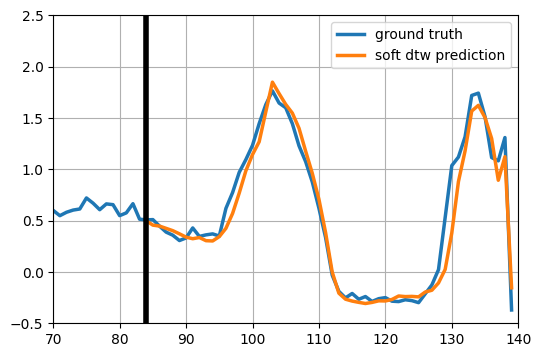

In [20]:
idx = 2185
x, target, pred, loss_dtw, loss_eucl = l[idx]

print(f'DTW metric: {dtw_metric(target, pred):.4f}')
print(f'Euclidian metric: {euclidian_metric(target, pred):.4f}')

index_1 = range(len(x))
index_2 = range(len(x), len(x)+len(target))

plt.figure(figsize=(6,4))
plt.plot(np.concatenate([index_1, index_2]), np.concatenate([x, target]), label='ground truth', linewidth=2.5)
plt.plot(index_2, pred, label='soft dtw prediction', linewidth=2.5)
plt.axvline(x=len(x), c='k', linewidth=4)
plt.xlim((70,140))
plt.ylim((-0.5, 2.5))
plt.grid()
plt.legend(loc="upper right")
plt.savefig('sdtw.png')

##### Example SDTW$^\gamma$ model's output ($\gamma=0.05$)

DTW metric: 4.0070
Euclidian metric: 1.2987


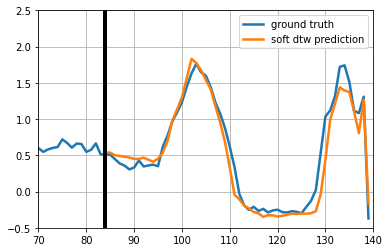

In [ ]:
idx = 2185
x, target, pred, loss_dtw, loss_eucl = l[idx]

print(f'DTW metric: {dtw_metric(target, pred):.4f}')
print(f'Euclidian metric: {euclidian_metric(target, pred):.4f}')

index_1 = range(len(x))
index_2 = range(len(x), len(x)+len(target))

plt.figure(figsize=(6,4))
plt.plot(np.concatenate([index_1, index_2]), np.concatenate([x, target]), label='ground truth', linewidth=2.5)
plt.plot(index_2, pred, label='soft dtw prediction', linewidth=2.5)
plt.axvline(x=len(x), c='k', linewidth=4)
plt.xlim((70,140))
plt.ylim((-0.5, 2.5))
plt.grid()
plt.legend(loc="upper right")
plt.savefig('sdtw.png')